# 08-03 - Adjacency Matrix Factorization

*June 14 2023*  

We introduce singular value decomposition (SVD), a generalization of the eigendecomposition for square normal matrices to arbitrary non-square matrices. We show how we can apply SVD to adjacency matrices to find low-dimensional representations of graphs that can be used for link prediction.

In [1]:
import pathpyG as pp

import numpy as np
import scipy.stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from matplotlib.collections import LineCollection

from sklearn.linear_model import LogisticRegression

from sklearn import datasets

from scipy.stats import multivariate_normal
from matplotlib import cm

import sklearn
from sklearn.decomposition import PCA
from sklearn import linear_model

from scipy.linalg import svd

plt.style.use('default')
sns.set_style("whitegrid")

In [2]:
import torch
from sklearn.model_selection import train_test_split

def generate_link_prediction_datasets(g, test_ratio=0.3, add_self_loops=True):
    """
    Generates link unsupervised prediction datasets from the input graph.
    Thas is, we get a dataset with edge_index we can use for training, 
    and y_index and y keys for indexes of test edges (both positive and negative samples) 
    and labels (as positive or negative sample) respectively

    Args:
        g (ppG.graph): The input graph data object.
        test_ratio (float): The fraction of edges to be used for the test set.

    Returns:
        - link_prediction_data (torch_geometric.data.Data): A ppG graph object
    """
    def add_edge_index_self_loops(edge_index, num_nodes):
        # useful to avoid truobles from pyG imposing contiguous edge indices
        all_nodes = set(range(num_nodes))
        unique_nodes = set(edge_index[0].tolist()) | set(edge_index[1].tolist())
        isolated_nodes = torch.tensor(list(all_nodes - unique_nodes)).long()
        isolated_self_loops = torch.stack([isolated_nodes, isolated_nodes], dim=0)
        edge_index = torch.cat([edge_index, isolated_self_loops], dim=1)
        return edge_index

    negative_sample = pyG.utils.negative_sampling(g.data.edge_index, num_neg_samples = int(g.M*test_ratio))

    edges =  g.data.edge_index.t().tolist()
    train_edges, test_edges = train_test_split(edges, test_size=test_ratio)

    positive_sample = torch.tensor(test_edges).t()

    train_edge_index = torch.tensor(train_edges).t()
    y_index = torch.cat((positive_sample, negative_sample), dim=1)
    y = torch.cat((torch.ones(positive_sample.shape[1]), torch.zeros(negative_sample.shape[1])), dim=0)

    data = pyG.data.Data(
        edge_index=train_edge_index,
        y_index=y_index,
        y=y,
        pos=g.data.pos,
        num_nodes = g.N
    )

    if add_self_loops:
        data.edge_index = add_edge_index_self_loops(data.edge_index, data.num_nodes)

    return data

In [3]:

g = pp.Graph.from_edge_list([
    ('a', 'b'),
    ('b', 'c'),
    ('a', 'c'),
    ('b', 'd'),
    ('d', 'f'),
    ('d', 'g'),
    ('d', 'e'),
    ('e', 'f'),
    ('f', 'g')]
    ).to_undirected()

pp.plot(g)#,node_label = g.mapping.node_ids)

In notebook 08-01, we found that the rows/columns of the adjacency matrix can be viewed as vector representation of the corresponding nodes, where the distance between vectors yields a similarity between nodes. In lecture L07 we have also seen that the cosine between those vectors yields a similarity metric that corresponds to the number of common neighbors, divided by the geometric mean of the node degrees.

In our experiment, we used the full columns of the adjacency matrix, which is not feasible in networks with hundreds of millions of nodes. Moreover, it is difficult to interpret the resulting latent space representation of nodes and due to the large number of dimensions we face the curse of dimensionality and introduce a large potential of overfitting. 

We have seen that using subsets of two components from the adjacency matrix did not yield meaningful results for link prediction, even though we know that the underlying network topology was generated based on a two-dimensional (latent space). To find a meaningful embedding in a low-dimensional space, we need dimensionality reduction techniques. 

## Eigendecomposition of Adjacency Matrix

We first use an approach that loosely resembles PCA, where we can view the adjacency matrix as a kind of `covariance` matrix. We calculate the eigenvalues and construct a diagonal matrix $\Delta \in \mathbf{R}^{n \times n}$ where the diagonal entries are the eigenvalues in descending order. We further calculate an eigenmatrix, where the columns are the associated eigenvectors. Like in PCA, we can use the (truncated) eigenmatrix to project our original data. We specifically calculate $X = U \cdot |\Delta|^{\frac{1}{2}}$ and interpret the rows/columns as vector space representation of nodes. 

Note that we have to take the absolute value of the eigenvalues since, different from the covariance matrix in PCA, our original adjacency matrix is not positive semidefinite, i.e. we generally have negative eigenvalues. We thus calculate the square roots of the absolute value of the eigenvalues and store the signs of the original eigenvalues in a matrix $S$. To recover the original matrix, we can then calculate 

$A = X \cdot S \cdot X^T$

The first entries in the rows/columns $x_i, x_j$ of matrix $X$ yield a new vector space representation of nodes $i$ and $j$ that minimizes the loss function

$$ L = \sum_{i,j} \| \vec{x}_i \cdot S \cdot \vec{x}_j^T - A_{ij} \|^2$$

where $S = sign(\Delta)$.

In the following, we compute the eigendecomposition for the example network:

In [4]:
A = g.get_sparse_adj_matrix().todense()    
ew, ev = np.linalg.eig(A)

# eigenmatrix 
U = ev[:,np.argsort(-ew)]

# eigenvalues
ew = -np.sort(-ew)
print(ew)

# compute diagonal matrix of eigenvalues
D = np.diag(ew)

# compute sign matrix S
sign = np.sign(D)
print(sign)

# embedding matrix
X = U @ np.sqrt(np.abs(D))
print(X)

[ 2.7730377e+00  1.9188904e+00 -5.0299692e-17 -4.3750685e-01
 -1.0000000e+00 -1.3616153e+00 -1.8928057e+00]
[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.]]
[[-3.1977004e-01 -7.3602188e-01  2.7204465e-27 -2.3816586e-01
   7.0710677e-01 -1.5672386e-01  2.5039113e-01]
 [-5.6696433e-01 -6.7632335e-01 -6.4786077e-26  3.4236506e-01
  -5.4699418e-16  3.7012145e-01 -7.2433281e-01]
 [-3.1977004e-01 -7.3602188e-01  6.4786077e-26 -2.3816586e-01
  -7.0710677e-01 -1.5672386e-01  2.5039113e-01]
 [-9.3267334e-01  1.7425339e-01 -5.4408931e-27  3.2654464e-01
  -9.7110296e-17 -1.9051534e-01  8.7023914e-01]
 [-6.1848390e-01  3.0236876e-01 -5.0149622e-09 -1.0155942e-01
  -2.0446305e-16 -4.7185999e-01 -4.9090025e-01]
 [-7.8240597e-01  4.0595904e-01 -4.9474467e-25 -2.8211173e-01
   8.0499650e-16  8.3300716e-01  5.8939673e-02]
 [-6.1848390e-

We can now recover the original adjacency matrix as follows (up to numerical precision issues):

In [5]:
print(X @ sign @ X.T)

[[ 3.3285218e-08  1.0000001e+00  1.0000000e+00 -5.5000271e-10
  -4.2472525e-08 -6.3111942e-09 -4.2472525e-08]
 [ 1.0000001e+00  6.5072527e-08  1.0000001e+00  9.9999994e-01
  -1.1711165e-08  2.2709443e-08 -1.1711165e-08]
 [ 1.0000000e+00  1.0000001e+00  3.3285218e-08 -5.5000271e-10
  -4.2472525e-08 -6.3111942e-09 -4.2472525e-08]
 [-5.5000271e-10  9.9999994e-01 -5.5000271e-10  1.3297539e-07
   9.9999994e-01  1.0000000e+00  9.9999994e-01]
 [-4.2472525e-08 -1.1711165e-08 -4.2472525e-08  9.9999994e-01
   2.7155433e-10  1.0000000e+00  2.7155433e-10]
 [-6.3111942e-09  2.2709443e-08 -6.3111942e-09  1.0000000e+00
   1.0000000e+00  1.2177625e-08  1.0000000e+00]
 [-4.2472525e-08 -1.1711165e-08 -4.2472525e-08  9.9999994e-01
   2.7155433e-10  1.0000000e+00  2.7155433e-10]]


In [6]:
print(A)

[[0. 1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0. 1. 0.]]


Let us implement this in a function that generates a truncated vector space representation of nodes:

In [7]:
def eigen_embedding(g, d=None):
    if d == None:
        d = g.N-1

    # compute all eigenvectors in ascending order
    A = g.get_sparse_adj_matrix().todense()    
    ew, ev = np.linalg.eig(A)

    # eigenmatrix 
    U = ev[:,np.argsort(-ew)]

    # eigenvalues
    ew = -np.sort(-ew)

    S = np.diag(np.sqrt(np.abs(ew)))

    X = U @ S

    vecs = {}
    for v in g.nodes:
        projection = X[g.mapping.id_to_idx[v]]
        vecs[v] = np.squeeze(np.asarray(projection[:,:d+1].real))

    return vecs, np.sign(np.diag(ew))[0:d+1, 0:d+1]

We test this in our example network.

In [8]:
embedding, _ = eigen_embedding(g)
print(embedding)

{np.str_('a'): array([-3.1977004e-01, -7.3602188e-01,  2.7204465e-27, -2.3816586e-01,
        7.0710677e-01, -1.5672386e-01,  2.5039113e-01], dtype=float32), np.str_('b'): array([-5.6696433e-01, -6.7632335e-01, -6.4786077e-26,  3.4236506e-01,
       -5.4699418e-16,  3.7012145e-01, -7.2433281e-01], dtype=float32), np.str_('c'): array([-3.1977004e-01, -7.3602188e-01,  6.4786077e-26, -2.3816586e-01,
       -7.0710677e-01, -1.5672386e-01,  2.5039113e-01], dtype=float32), np.str_('d'): array([-9.3267334e-01,  1.7425339e-01, -5.4408931e-27,  3.2654464e-01,
       -9.7110296e-17, -1.9051534e-01,  8.7023914e-01], dtype=float32), np.str_('e'): array([-6.1848390e-01,  3.0236876e-01, -5.0149622e-09, -1.0155942e-01,
       -2.0446305e-16, -4.7185999e-01, -4.9090025e-01], dtype=float32), np.str_('f'): array([-7.8240597e-01,  4.0595904e-01, -4.9474467e-25, -2.8211173e-01,
        8.0499650e-16,  8.3300716e-01,  5.8939673e-02], dtype=float32), np.str_('g'): array([-6.1848390e-01,  3.0236876e-01,  5.0

We find that the nodes `a` and `c` as well as `e` and `g` have the same embeddings. This is easy to understand since both nodes have identical neighborhoods.

In [9]:
print(embedding['a'])
print(embedding['c'])

[-3.1977004e-01 -7.3602188e-01  2.7204465e-27 -2.3816586e-01
  7.0710677e-01 -1.5672386e-01  2.5039113e-01]
[-3.1977004e-01 -7.3602188e-01  6.4786077e-26 -2.3816586e-01
 -7.0710677e-01 -1.5672386e-01  2.5039113e-01]


In [10]:
print(embedding['e'])
print(embedding['g'])

[-6.1848390e-01  3.0236876e-01 -5.0149622e-09 -1.0155942e-01
 -2.0446305e-16 -4.7185999e-01 -4.9090025e-01]
[-6.1848390e-01  3.0236876e-01  5.0149622e-09 -1.0155942e-01
 -2.0446305e-16 -4.7185999e-01 -4.9090025e-01]


In [11]:
def plot_embedding(network, embedding, figsize=[4,8], edgewidth=1, pointsize = 50, node_labels=True):
    """Function that plots a network in matplotlib, where nodes are assigned coordinates based on the embedding"""
    
    p_x = [embedding[x][0] for x in embedding]
    p_y = [embedding[x][1] for x in embedding]

    fig, ax = plt.subplots()
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])
    ax.scatter(p_x, p_y, s=80)
    ax.set_xlabel(r'$v_1$', fontsize=14)
    ax.set_ylabel(r'$v_2$', fontsize=14)

    for v,w in network.edges:
        ax.annotate("", xy=(embedding[v][0], embedding[v][1]), xytext=(embedding[w][0], embedding[w][1]), arrowprops=dict(arrowstyle='-', color='gray'))

    if node_labels:
        for v in network.nodes:
            ax.annotate(v, (embedding[v][0]+0.01, embedding[v][1]+0.01), fontsize=20)

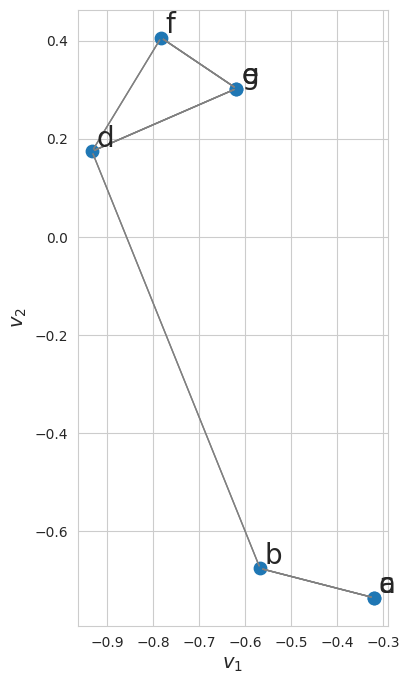

In [12]:
plot_embedding(g, embedding)

The dot product between those embeddings can be used to approximate adjacency matrix entries. Let us start by using all seven dimensions:

In [13]:
embedding, sign = eigen_embedding(g, d=7)

print(embedding['a'].T @ sign @ embedding['b'])
print(A[g.mapping.id_to_idx['a'], g.mapping.id_to_idx['b']])

1.0
1.0


In [14]:
print(embedding['b'].T @ sign @ embedding['b'])
print(A[g.mapping.id_to_idx['b'], g.mapping.id_to_idx['b']])

7.4505806e-08
0.0


In [15]:
print(embedding['d'].T @ sign @ embedding['f'])
print(A[g.mapping.id_to_idx['d'], g.mapping.id_to_idx['f']])

1.0
1.0


In [16]:
print(embedding['b'] @ sign @ embedding['g'])
print(A[g.mapping.id_to_idx['b'], g.mapping.id_to_idx['g']])

0.0
0.0


Let us now try this with a truncated vector space representation:

In [17]:
embedding, sign = eigen_embedding(g, d=2)

print(embedding['a'].T @ sign @ embedding['b'])
print(A[g.mapping.id_to_idx['a'], g.mapping.id_to_idx['b']])

0.679087
1.0


In [18]:
print(embedding['b'].T @ sign @ embedding['b'])
print(A[g.mapping.id_to_idx['b'], g.mapping.id_to_idx['b']])

0.7788618
0.0


In [19]:
print(embedding['d'].T @ sign @ embedding['f'])
print(A[g.mapping.id_to_idx['d'], g.mapping.id_to_idx['f']])

0.8004689
1.0


In [20]:
print(embedding['b'] @ sign @ embedding['g'])
print(A[g.mapping.id_to_idx['b'], g.mapping.id_to_idx['g']])

0.14615925
0.0


# Singular Value Decomposition of Adjacency Matrix

Instead of a factorization of the adjacency matrix based on the eigenvectors and eigenvalues, we can also use a singular value decomposition, i.e. the generalization of the eigendecomposition to arbitrary matrices. This has the benefit that we can also apply this to asymmetric matrices, or even non-square matrices (e.g. for bipartite networks).

Let us consider a factorization of an adjacency matrix $A \in \mathbb{R}^{n \times n}$ as 

$$ A = U V^T $$

where $U,V \in \mathbb{R}^{n \times d}$ for some $d<n$. We note that the product of an $n \times d$ with an $d \times n$ matrix yields a square matrix $\mathbb{R}^{n \cdot n}$.

We can interpret the entries of those two matrices as $d$-dimensional vector space coordinates. We would like to assign those coordinates such that the result of the product approximates our original matrix as good as possible. We can do this by minimizing the **Frobenius distance** between our original matrix $\mathbf{A}$ and the factorization $\mathbf{U}\mathbf{V}^T$, i.e. 

$$ \min{\| A- UV^T \|^2_F} $$ 

where 

$$ \|A \|_F^2 := \sqrt{\sum_{i=1}^n \sum_{j=1}^m |A_{i,j}|^2} $$

is the Frobenius distance.

Let us apply this to the adjacency matrix of our toy example network. We can use the `scipy` function `svd` to calculate the singular value decomposition of a matrix. The `svd` function returns positive singular values `s` in descending order, i.e. in the order of decreasing importance. In fact, the singular values of a matrix correspond to the square root of the eigenvalues of a matrix if the matrix has no negative eigenvalues, which we have seen to not be the case for an adjacency matrix! In this sense, the SVD is not equivalent to the eigendecomposition that we have done above (where we had to take special care due to the negative eigenvalues).


In [21]:
A = g.get_sparse_adj_matrix().todense()
U, singular_values, Vt = svd(A)

print('U =', U)
print('Sigma =', singular_values)
print('V^T=', Vt)

U = [[-1.9202596e-01 -5.3133458e-01  1.8198887e-01  1.3431020e-01
   7.0710659e-01  3.6007011e-01  4.9222129e-09]
 [-3.4046945e-01 -4.8822591e-01 -5.2649248e-01 -3.1718835e-01
   3.7031592e-07 -5.1760328e-01 -9.4388263e-08]
 [-1.9202600e-01 -5.3133464e-01  1.8198851e-01  1.3430920e-01
  -7.0710689e-01  3.6007017e-01  9.4388263e-08]
 [-5.6008184e-01  1.2578198e-01  6.3253874e-01  1.6326885e-01
  -5.0046691e-07 -4.9368507e-01 -5.0957635e-08]
 [-3.7140730e-01  2.1828507e-01 -3.5680911e-01  4.0437666e-01
  -2.7694949e-07  1.5354228e-01 -7.0710671e-01]
 [-4.6984455e-01  2.9305992e-01  4.2845603e-02 -7.1387392e-01
   5.1281205e-07  4.2650923e-01 -1.2706761e-07]
 [-3.7140730e-01  2.1828498e-01 -3.5680869e-01  4.0437651e-01
  -2.6204833e-07  1.5354227e-01  7.0710695e-01]]
Sigma = [2.7730379e+00 1.9188896e+00 1.8928056e+00 1.3616153e+00 9.9999982e-01
 4.3750682e-01 7.0106614e-09]
V^T= [[-1.9202597e-01 -3.4046915e-01 -1.9202624e-01 -5.6008208e-01
  -3.7140730e-01 -4.6984446e-01 -3.7140730e-01]
 

We can reconstruct the adjacency matrix from the singular value decomposition. If we use all $n$ singular vectors, we can (up to numerical precision) fully recover all entries of our adjacency matrix.

In [22]:
Sigma = np.diag(singular_values)
A_reconstructed = U @ Sigma @ Vt
print(A_reconstructed)

[[-5.0882869e-07  1.0000001e+00  9.9999928e-01 -4.7709733e-07
   3.3450115e-07  1.5755946e-07  2.9232396e-07]
 [ 9.9999946e-01 -1.8355347e-07  9.9999923e-01  1.0000002e+00
   4.6275818e-07  6.1786369e-07  5.7705563e-07]
 [ 9.9999952e-01  9.9999982e-01 -2.0969688e-07 -8.9855327e-08
   4.8266213e-07 -2.6514876e-08  3.6411649e-07]
 [ 1.3773314e-07  9.9999976e-01  6.9688235e-07 -5.4309155e-08
   9.9999952e-01  9.9999934e-01  9.9999958e-01]
 [ 7.1067511e-08 -2.7258173e-07  3.4762618e-07  1.0000002e+00
  -3.2380868e-07  1.0000000e+00 -3.6620222e-07]
 [ 3.0305347e-07 -2.3289081e-07  3.8333479e-07  1.0000001e+00
   9.9999970e-01 -2.9025659e-07  9.9999976e-01]
 [ 4.0222631e-08  1.5942078e-07  3.4099571e-07  9.9999958e-01
  -1.9493442e-08  9.9999976e-01 -9.0809486e-08]]


We can compare this to the original matrix and calculate the Frobenius norm:

In [23]:
print(A)

[[0. 1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0. 1. 0.]]


In [24]:
np.linalg.norm(A_reconstructed-A, ord='fro')

np.float32(2.5751692e-06)

Like in PCA, we can use only the first $d$ dimensions to reconstruct the original matrix. The magnitude of singular values tells us the relative importance of the corresponding dimension.

In [25]:
print(singular_values)

[2.7730379e+00 1.9188896e+00 1.8928056e+00 1.3616153e+00 9.9999982e-01
 4.3750682e-01 7.0106614e-09]


We can now just use the first $d$ singular values, as well as the associated rows/columns of matrices $\mathbf{U}$ and $\mathbf{V}^T$ (the singular vectors) to (approximately) recover a version $A_d$ of the original matrix as

$$ A_d = \sum_{i=1}^d{\sigma_i \mathbf{u}_i \mathbf{v}_i^T} $$

Technically, with this we project the columns of our adjacency matrix onto the vector space that is spanned by the first $k$ singular vectors $v_i$.

In [26]:
def recover_matrix(Sigma, Vt, U, d):
    sd = Sigma[:, :d]
    Vtd = Vt[:d, :]
    return U @ sd @ Vtd

If we use four of the seven singular values, we can approximately recover the adjacency matrix.

In [27]:
recover_matrix(Sigma, Vt, U, d=4)

array([[ 0.5567222 ,  0.91846067,  0.55672246, -0.0777724 ,  0.02418823,
         0.06718991,  0.02418818],
       [ 0.9184601 ,  0.11721367,  0.9184593 ,  1.1117977 , -0.03476993,
        -0.09658457, -0.03476986],
       [ 0.5567226 ,  0.9184599 ,  0.5567228 , -0.0777717 ,  0.02418855,
         0.06718896,  0.02418851],
       [-0.07777195,  1.1117972 , -0.07777074,  0.10663129,  0.96683586,
         0.9078773 ,  0.96683586],
       [ 0.02418787, -0.03477069,  0.02418855,  0.9668365 ,  0.010314  ,
         1.0286511 ,  0.01031396],
       [ 0.06718999, -0.09658538,  0.06718938,  0.90787816,  1.0286508 ,
         0.07958667,  1.0286509 ],
       [ 0.02418785, -0.03477025,  0.02418853,  0.9668359 ,  0.0103143 ,
         1.0286509 ,  0.01031424]], dtype=float32)

In [28]:
np.linalg.norm(recover_matrix(Sigma, Vt, U, 4)-A, ord='fro')

np.float32(1.0915183)

Just like for PCA, the reconstruction loss increases if we decrease the number of singular values and vectors that we use.

In [29]:
recover_matrix(Sigma, Vt, U, d=2)

array([[ 0.6439806 ,  0.6790989 ,  0.64398056,  0.16997476, -0.02477232,
        -0.04860699, -0.02477233],
       [ 0.67907417,  0.77886146,  0.6790743 ,  0.41093323,  0.14616929,
         0.16904174,  0.14616928],
       [ 0.6439807 ,  0.679099  ,  0.6439806 ,  0.1699748 , -0.0247723 ,
        -0.048607  , -0.02477231],
       [ 0.1699986 ,  0.41094863,  0.16999906,  0.9002435 ,  0.62952584,
         0.80046237,  0.62952584],
       [-0.02478217,  0.14614965, -0.02478182,  0.6295383 ,  0.47394907,
         0.6066583 ,  0.47394907],
       [-0.04860226,  0.169032  , -0.0486018 ,  0.80047494,  0.606651  ,
         0.7769616 ,  0.606651  ],
       [-0.02478207,  0.14614974, -0.02478173,  0.62953824,  0.47394902,
         0.6066582 ,  0.47394902]], dtype=float32)

In [30]:
np.linalg.norm(recover_matrix(Sigma, Vt, U, 2)-A, ord='fro')

np.float32(2.574514)

It can be shown that the matrix $A_d$ that we recover based on the first $k$ singular values and singular vectors is the best rank $k$ approximation of the original matrix $\mathbf{A}$ in terms of the Frobenius norm. This explains the importance of the singular value decomposition for dimensionality reduction tasks. Rather than the adjacency matrix columns, we can now use the first $d$ singular vectors to obtain a low-dimensional vector space representation of a graph.

In [31]:
def svd_embedding(g, d=None):
    """Returns a vector representation of nodes based on the (truncated) SVD of the adjacency matrix"""
    
    if d == None:
        d = g.N

    # compute SVD
    A =g.get_sparse_adj_matrix().todense()
    U, sigma, Vt = svd(A)
    
    vecs = {}
    for v in g.nodes:
        # embedding of node i in d-dimensional vector space is given by 
        # i-th component in the first d singular vectors
        vecs[v] = U[g.mapping.id_to_idx[v],:d].real

    return vecs

In [32]:
embedding = svd_embedding(g, d=2)
print(embedding)


{np.str_('a'): array([-0.19202596, -0.5313346 ], dtype=float32), np.str_('b'): array([-0.34046945, -0.4882259 ], dtype=float32), np.str_('c'): array([-0.192026  , -0.53133464], dtype=float32), np.str_('d'): array([-0.56008184,  0.12578198], dtype=float32), np.str_('e'): array([-0.3714073 ,  0.21828507], dtype=float32), np.str_('f'): array([-0.46984455,  0.29305992], dtype=float32), np.str_('g'): array([-0.3714073 ,  0.21828498], dtype=float32)}


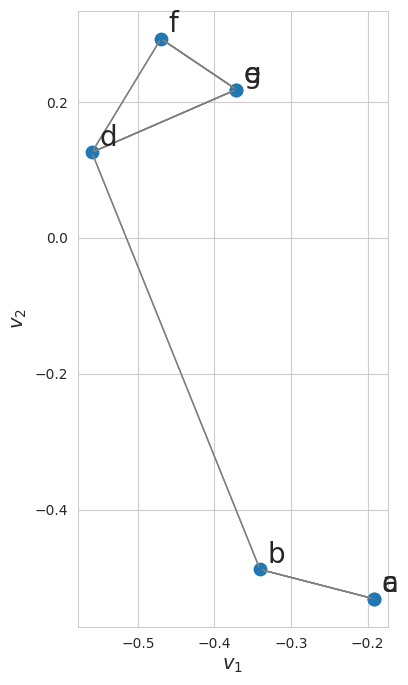

In [33]:
plot_embedding(g, embedding)

We again find that the node pairs e and g and a and b are assigned to the same position, which can be understood based on the fact that those two nodes have exactly the same neighborhoods. Indeed, we have seen that using the cosine similarity measure in the adjacency matrix, those nodes are assigned the same similarity (value 1) as the cosine similarity of a node to itself. So, from the perspective of SVD on the adjacency matrix, those two nodes are actually identical.

## Application to Unsupervised Link Prediction

We can now apply our knowledge about matrix factorization and graph representation learning to unsupervised link prediction. We reuse the function from notebook 08-01 to generate a random geometric network with a soft connection rule.

In [34]:
import torch_geometric as pyG

def random_geometric_net(n, dim, dist, rule, lcc=True, **kwargs):

    # generate empty graph and assign random node positions
    data = pyG.data.Data()
    
    nodes = []
    data.pos = torch.zeros((n,dim))
    for i in range(n):
        nodes.append(i)
        data.pos[i] = torch.tensor([np.random.random() for x in range(dim)])
    
    # compute node similarity and add edges
    sources = []
    targets = []
    for v in range(n):
        for w in range(v+1,n):
            if rule(dist(data.pos[v], data.pos[w]), **kwargs):
                sources.append(v)
                targets.append(w)
    data.edge_index = torch.tensor([sources,targets])
    if lcc:
        lcc_transform = pyG.transforms.LargestConnectedComponents()
        data = lcc_transform(data)
    g = pp.Graph(data)
    g.mapping = pp.IndexMap(list(range(n)))
    return g.to_undirected()

def euclidean_dist(x, y):
    return np.linalg.norm(x-y)

def hard_rule(dist, **kwargs):
    if dist < kwargs['threshold']:
        return True
    else:
        return False

def soft_rule(dist, **kwargs):
    p = kwargs['beta'] * np.exp(-dist/kwargs['alpha'])
    if np.random.random() <= p:
        return True
    else:
        return False

def euclidean_sim(x, y):
    return -euclidean_dist(x, y)

def cosine_sim(x, y):
    return x.dot(y)    

In [35]:
g = random_geometric_net(n=100, dim=2, dist=euclidean_dist, rule=soft_rule, pos=None, alpha=0.03, beta=70)
pp.plot(g,
        # node_label = g.mapping.node_ids, 
        layout = dict(zip([int(i) for i in g.nodes], g.data.pos.tolist()))
        )

We again create a test and train set of edges and add negative samples to obtain a balanced test set.

In [36]:
# link_prediction_data, train_data, val_data, test_data = generate_link_prediction_datasets(g)
link_prediction_data = generate_link_prediction_datasets(g)
link_prediction_data.pos = g.data.pos

We finally reuse the functions to assign similarity scores to node pairs and to compute the ROC of the resulting similarity-based (i.e. unsupervised link prediction):

In [37]:
def assign_sim(data, sim_score):
    # notice how the similarity is computed on the node couples that will be used for testing
    v_pos = data.pos[data.y_index[0]]
    w_pos = data.pos[data.y_index[1]]
    data.sim = torch.tensor([sim_score(v, w) for v, w in zip(v_pos, w_pos)])
    return data

In [38]:
def compute_ROC(data, plot=True):
    fpr, tpr, thresholds = metrics.roc_curve(data.y, data.sim)
    if plot:
        plt.plot(fpr, tpr)
        plt.plot(np.linspace(0,1), np.linspace(0,1), ls='--', c='r', alpha=0.5)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.tight_layout()
    auc = metrics.auc(fpr, tpr)
    return auc

Let's now compute our two embeddings based on the eigendecomposition and the SVD:

In [39]:
train_network = pp.Graph(link_prediction_data)
train_network.mapping = g.mapping # TODO: maybe this avoided implementing ppG own split


eigen_emb = eigen_embedding(train_network, d=2)[0]
svd_emb = svd_embedding(train_network, d=2)

/tmp/ipykernel_18/1796413218.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  link_prediction_data.pos = torch.tensor([eigen_emb[g.mapping.to_ids(node_idx)] for node_idx in range(train_network.N)] )


np.float64(0.7970471027944852)

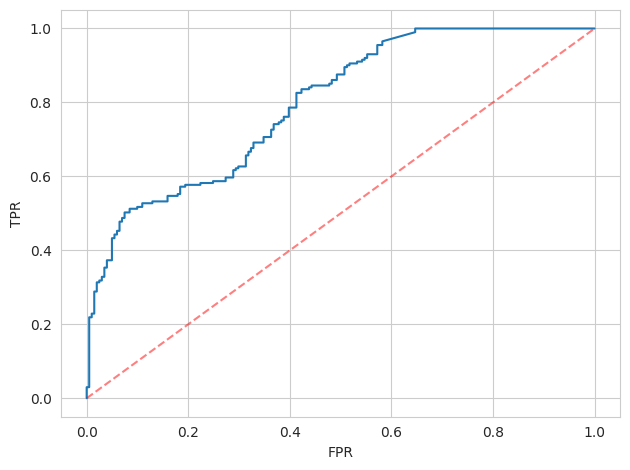

In [40]:
link_prediction_data.pos = torch.tensor([eigen_emb[g.mapping.to_ids(node_idx)] for node_idx in range(train_network.N)] )

assign_sim(link_prediction_data, cosine_sim)
compute_ROC(link_prediction_data)

np.float64(0.7501546991411103)

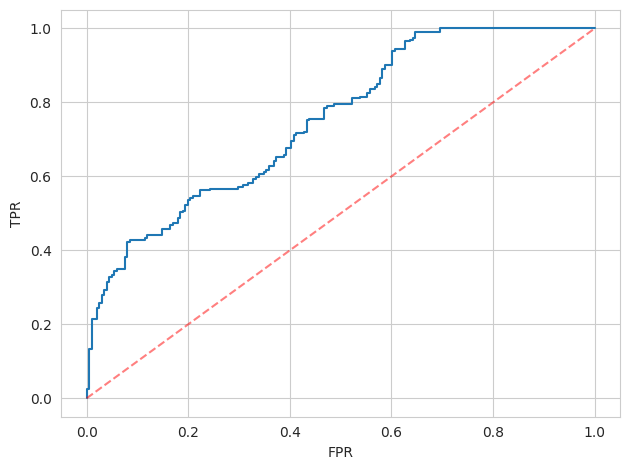

In [41]:
link_prediction_data.pos = torch.tensor([svd_emb[g.mapping.to_ids(node_idx)] for node_idx in range(train_network.N)] )

assign_sim(link_prediction_data, cosine_sim)
compute_ROC(link_prediction_data)

In [42]:
eigen_emb = eigen_embedding(train_network, d=20)[0]
svd_emb = svd_embedding(train_network, d=20)

np.float64(0.9265735996633747)

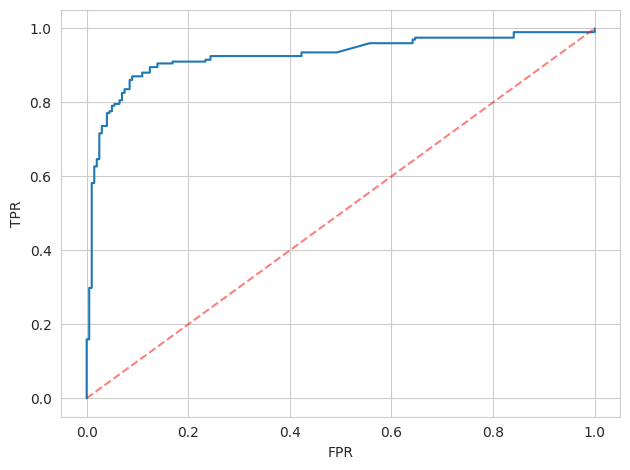

In [43]:
link_prediction_data.pos = torch.tensor([eigen_emb[g.mapping.to_ids(node_idx)] for node_idx in range(train_network.N)] )

assign_sim(link_prediction_data, cosine_sim)
compute_ROC(link_prediction_data)

np.float64(0.8506225093438281)

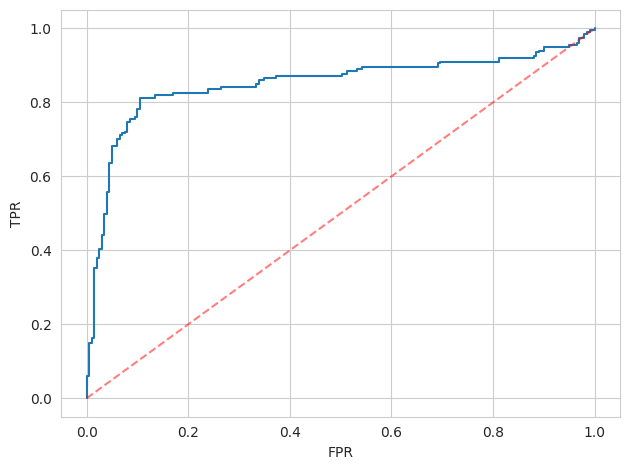

In [44]:
link_prediction_data.pos = torch.tensor([svd_emb[g.mapping.to_ids(node_idx)] for node_idx in range(train_network.N)] )

assign_sim(link_prediction_data, cosine_sim)
compute_ROC(link_prediction_data)

## Embedding in higher-dimensional spaces

In the example above, the links in the network can be "explained" based on randomly generated two-dimensional node positions. But what if we have a network where we need more than two dimensions to "explain" (and thus predict) the links? 

The method `random_geometric_net` has a parameter that controls the dimension of the randomly generated coordinates. We can use this to generate a network that is constructed from a higher-dimensional latent space:

In [45]:
g = random_geometric_net(n=100, dim=4, dist=euclidean_dist, rule=lambda x: True if x < 0.4 else False)

In fact, all of the methods above have been implemented such that they work with arbitrary dimensions (e.g. the Euclidean distance and similarity functions). There is one exception: `pathpy` naturally expects two-dimensional coordinates to visualize a network, so we need a function that "projects" positions in the latent space to two-dimensional coordinates. The following function just uses the first two dimensions of the coordinates:

In [46]:
def to2d(pos):
    return { k: v[:2] for k,v in pos.items() }

In [47]:
pp.plot(g,
        # node_label = g.mapping.node_ids,
        layout = to2d(dict(zip([int(i) for i in g.nodes], g.data.pos.tolist()))) 
        )

We generate training and test networks

In [48]:

link_prediction_data = generate_link_prediction_datasets(g)
link_prediction_data.pos = g.data.pos

In [49]:
train_network = pp.Graph(link_prediction_data)
train_network.mapping = g.mapping

An embedding in a two-dimensional space cannot predict all of the links, as it cannot capture the topology of the latent space.

np.float64(0.8296269095182139)

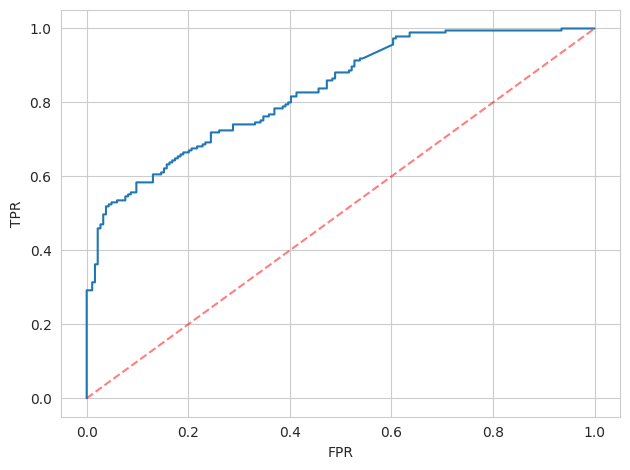

In [50]:
eigen_emb = eigen_embedding(train_network, d=2)[0]

link_prediction_data.pos = torch.tensor([eigen_emb[g.mapping.to_ids(node_idx)] for node_idx in range(train_network.N)] )

assign_sim(link_prediction_data, cosine_sim)
compute_ROC(link_prediction_data)


np.float64(0.8920534665099883)

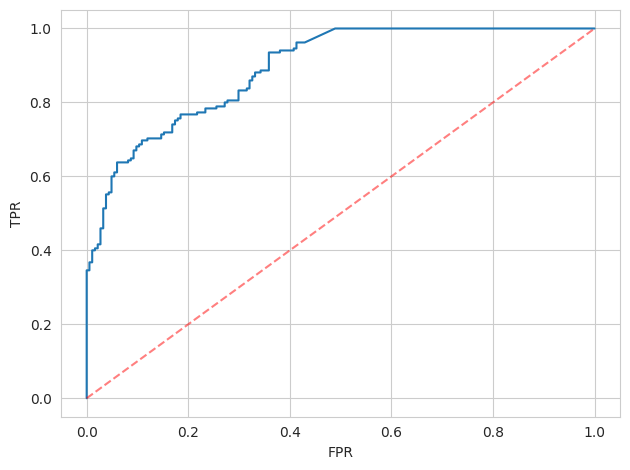

In [51]:
eigen_emb = eigen_embedding(train_network, d=4)[0]

link_prediction_data.pos = torch.tensor([eigen_emb[g.mapping.to_ids(node_idx)] for node_idx in range(train_network.N)] )

assign_sim(link_prediction_data, cosine_sim)
compute_ROC(link_prediction_data)


Let us investigate this more systematically. The following function generates a network based on a latent space with `data_dim` dimensions. It then generates `samples` train-test splits of the links (with negative samples), computes a Laplacian embedding in a `d` dimensional space and computes the average `AUC` of the link prediction. This is repeated for `d=1` to `max_dim` dimensions.

In [52]:
def AUC_dim(n=100, threshold=0.5, data_dim=2, embedding=eigen_embedding, max_dim=10, samples=10):
    # 1.) generate network 
    g = random_geometric_net(n=n, dist=euclidean_dist, rule=lambda x: True if x < threshold else False, dim=data_dim)
    aucs = []
    for d in range(1, max_dim):
        print('Computing AUC for embedding in {0}-dimensional space'.format(d))
        # 2.) train and test set 
        mean_auc = 0
        for i in range(samples):
            link_prediction_data = generate_link_prediction_datasets(g)
            train_network = pp.Graph(link_prediction_data)
            train_network.mapping = g.mapping

            if embedding == eigen_embedding:
                vecs = embedding(train_network, d=d)[0]
            else:
                vecs = embedding(train_network, d=d)
            link_prediction_data.pos = torch.tensor([vecs[g.mapping.to_ids(node_idx)] for node_idx in range(train_network.N)] )
            assign_sim(link_prediction_data,  cosine_sim)
            mean_auc += compute_ROC(link_prediction_data, plot=False)
        mean_auc = mean_auc / samples
        aucs.append(mean_auc)
    return aucs    

We can now plot the AUC of our link prediction (y-axis) for different dimensions $d$ of the embedding (x-axis). We find that a maximum is reached when the dimensionality of the embedding matches the dimensionality of the data (indicated as red vertical line), while the AUC remains roughly the same if we use more dimensions.

Computing AUC for embedding in 1-dimensional space
Computing AUC for embedding in 2-dimensional space
Computing AUC for embedding in 3-dimensional space
Computing AUC for embedding in 4-dimensional space
Computing AUC for embedding in 5-dimensional space
Computing AUC for embedding in 6-dimensional space
Computing AUC for embedding in 7-dimensional space
Computing AUC for embedding in 8-dimensional space
Computing AUC for embedding in 9-dimensional space


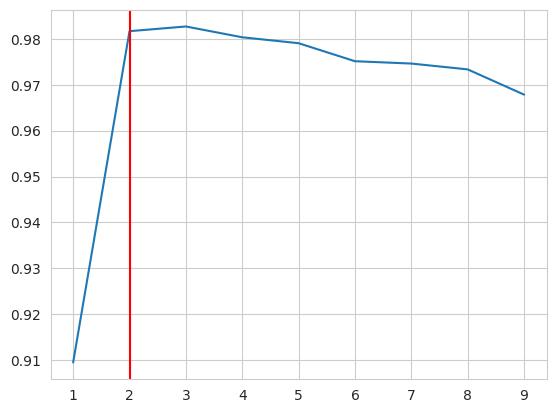

In [53]:
aucs = AUC_dim(data_dim=2, threshold=0.5, samples=20)
plt.plot(range(1, 10), aucs)
plt.axvline(x=2, color='red');

Computing AUC for embedding in 1-dimensional space
Computing AUC for embedding in 2-dimensional space
Computing AUC for embedding in 3-dimensional space
Computing AUC for embedding in 4-dimensional space
Computing AUC for embedding in 5-dimensional space
Computing AUC for embedding in 6-dimensional space
Computing AUC for embedding in 7-dimensional space
Computing AUC for embedding in 8-dimensional space
Computing AUC for embedding in 9-dimensional space


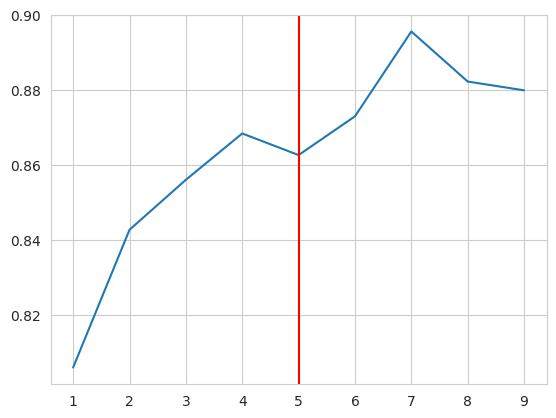

In [54]:
aucs = AUC_dim(data_dim=5, threshold=0.5)
plt.plot(range(1, 10), aucs)
plt.axvline(x=5, color='red')

Computing AUC for embedding in 1-dimensional space
Computing AUC for embedding in 2-dimensional space
Computing AUC for embedding in 3-dimensional space
Computing AUC for embedding in 4-dimensional space
Computing AUC for embedding in 5-dimensional space
Computing AUC for embedding in 6-dimensional space
Computing AUC for embedding in 7-dimensional space
Computing AUC for embedding in 8-dimensional space
Computing AUC for embedding in 9-dimensional space


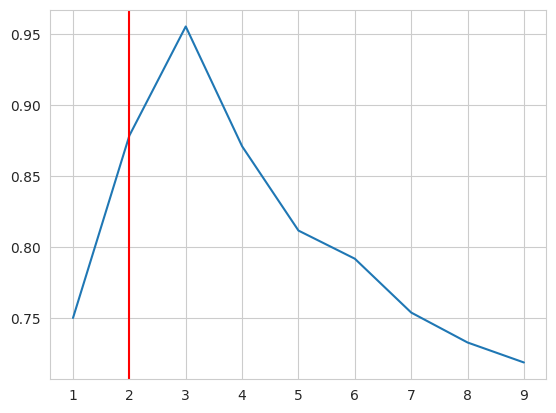

In [55]:
aucs = AUC_dim(data_dim=2,
 embedding=svd_embedding,
threshold=0.5)
plt.plot(range(1, 10), aucs)
plt.axvline(x=2, color='red');

Computing AUC for embedding in 1-dimensional space
Computing AUC for embedding in 2-dimensional space
Computing AUC for embedding in 3-dimensional space
Computing AUC for embedding in 4-dimensional space
Computing AUC for embedding in 5-dimensional space
Computing AUC for embedding in 6-dimensional space
Computing AUC for embedding in 7-dimensional space
Computing AUC for embedding in 8-dimensional space
Computing AUC for embedding in 9-dimensional space


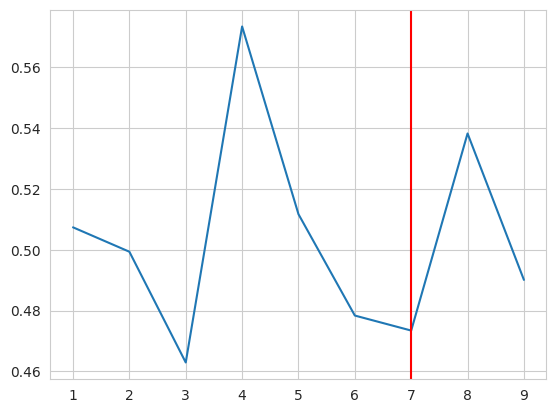

In [56]:

aucs = AUC_dim(data_dim=7, embedding=svd_embedding, threshold=0.5)
plt.plot(range(1, 10), aucs)
plt.axvline(x=7, color='red');